# NanoSafety data summary

- using aggregated search

In [1]:
import yaml
from solrscope import aa
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import requests
from importlib import reload 
from solrscope import client_solr
from solrscope import client_ambit
from solrscope import annotation
import pandas as pd
import numpy as np
import json
import pandas as pd
#import qgrid
import warnings
warnings.simplefilter("ignore")

In [2]:
print('Select enanoMapper aggregated search service:')
style = {'description_width': 'initial'}
config,config_servers, config_security, auth_object, msg = aa.parseOpenAPI3()    
service_widget = widgets.Dropdown(
    options=config_servers['url'],
    description='Service:',
    disabled=False,
    style=style
)
if config_security is None:
    service = interactive(aa.search_service_open,url=service_widget)
else:
    print(msg)
    apikey_widget=widgets.Text(
            placeholder='',
            description=config_security,
            disabled=False,
            style=style
    )    
    service = interactive(aa.search_service_protected,url=service_widget,apikey=apikey_widget)    

display(service)

Select enanoMapper aggregated search service:
Enter `X-Gravitee-Api-Key` you have received upon subscription to http://api.ideaconsult.net


interactive(children=(Dropdown(description='Service:', options=('https://api.ideaconsult.net/enanomapper', 'ht…

In [3]:
service_uri=service_widget.value
if auth_object!=None:
    auth_object.setKey(apikey_widget.value)
print("Sending queries to {}".format(service_uri))
facets = client_solr.Facets()


Sending queries to https://api.ideaconsult.net/enanomapper


In [4]:
    query_widget=widgets.Text(
        placeholder='',
        value="*:*",
        description="Query",
        disabled=False,
        style=style
    )
    display(query_widget)

Text(value='*:*', description='Query', placeholder='', style=DescriptionStyle(description_width='initial'))

In [5]:
method_field="E.method_s"
method_synonym="E.method_synonym_ss"
# method_field="guidance_s"

def summary(query=query_widget.value,fq="type_s:study",statistics="Number of data points",fields=["topcategory_s","endpointcategory_s",method_field,"substanceType_s","publicname_s","reference_owner_s"],log_query=None,log_result=None):
    colnames=["Z"]
    colnames.extend(fields)
    colnames.append(statistics)
    _stats=[]
    reload(client_solr)
    def process(prefix,val,count,key,_tuple):
        if len(_tuple)==len(fields):
            _tuple = (*_tuple,val,count)
            _stats.append(_tuple)
    q=facets.getQuery(query=query,facets=fields,fq=fq)
    if log_query!=None:
        log_query(q)
    
    r = client_solr.post(service_uri,query=q,auth=auth_object)
    response_json=r.json()

    if r.status_code==200:
        if log_result!=None:
            log_result(response_json)
        facets.parse(response_json['facets'],prefix=">",process=process)
        df = pd.DataFrame(_stats,columns=colnames).drop("Z", axis=1)
        if "substanceType_s" in df.columns:
            a = annotation.DictionarySubstancetypes()
            df[ 'substanceType_name']=df[ 'substanceType_s'].apply(a.annotate)
        if "substanceType_hs" in df.columns:
            a = annotation.DictionarySubstancetypes()
            df[ 'substanceType_name']=df[ 'substanceType_hs'].apply(a.annotate)            
        if "endpointcategory_s" in df.columns:    
            a = annotation.DictionaryEndpointCategory()
            df[ 'endpointcategory_term']=df[ 'endpointcategory_s'].apply(a.annotate)
            a = annotation.DictionaryEndpointCategoryNames()
            df[ 'endpointcategory_name']=df[ 'endpointcategory_s'].apply(a.annotate)
        
        if "method_term" in df.columns:
            a = annotation.DictionaryAssays()
            df[ 'method_term']=df[method_field].apply(a.annotate)
        return (df)
    else:
        print(r.status_code)
        return (None)
    
df = summary(query=query_widget.value,fields=["topcategory_s","endpointcategory_s",method_synonym,method_field,"substanceType_s","publicname_s","reference_owner_s"])    
df.head()

,topcategory_s,endpointcategory_s,E.method_synonym_ss,E.method_s,substanceType_s,publicname_s,reference_owner_s,Number of data points,substanceType_name,endpointcategory_term,endpointcategory_name
0,P-CHEM,PC_GRANULOMETRY_SECTION,_,_,NPO_401,G15.AC,_,13,gold nanoparticle,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)
1,P-CHEM,PC_GRANULOMETRY_SECTION,_,_,NPO_401,G15.AHT,_,13,gold nanoparticle,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)
2,P-CHEM,PC_GRANULOMETRY_SECTION,_,_,NPO_401,G15.AUT,_,13,gold nanoparticle,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)
3,P-CHEM,PC_GRANULOMETRY_SECTION,_,_,NPO_401,G15.Ala-SH,_,13,gold nanoparticle,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)
4,P-CHEM,PC_GRANULOMETRY_SECTION,_,_,NPO_401,G15.Asn-SH,_,13,gold nanoparticle,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)


In [6]:
table = pd.pivot_table(df, values='Number of data points', index=['topcategory_s','endpointcategory_name',method_synonym,method_field], columns=[ 'substanceType_s',"publicname_s"], aggfunc=np.sum).fillna("");
display(table)

table.reset_index().to_excel("method_material.xlsx")

substanceType_s                                                                      CHEBI_33416  \
publicname_s                                                                           Fullerene   
topcategory_s endpointcategory_name                   E.method_synonym_ss E.method_s               
P-CHEM        Appearance                              _                   _                        
              Aspect ratio/shape                      _                   _                        
              Crystallite and grain phase             _                   _                        
              Dustiness                               _                   _                        
              ENM_9000100_SECTION                     _                   _                        
              ENM_9000111_SECTION                     _                   _                        
              ENM_9000112_SECTION                     _                   _                        
              ENM_9000127_SECTION                     _                   _                        
              ENM_9000177_SECTION                     _                   _                        
              ENM_9000195_SECTION                     _                   _                        
              Melting point/freezing point            _                   _                    3   
              NPO_1204_SECTION                        _                   _                        
              NPO_1539_SECTION                        _                   _                        
              NPO_1694_SECTION                        _                   _                        
              NPO_1914_SECTION                        _                   _                        
              PATO_0000921_SECTION                    _                   _                        
              Particlesize distribution(Granulometry) _                   _                        
              Physchem(other)                         _                   _                    3   
              Specific surface area                   _                   _                        
              Surface chemistry                       _                   _                        
              Zeta potential                          _                   _                        
TOX           Acute toxicity-oral                     _                   _                        
              Carcinogenicity                         _                   _                        
              Cell Viability Assay                    _                   _                        
              Cytotoxicity Assay                      _                   _                        
              Genetic toxicity invitro                _                   _                        
              Genotoxicity Assay                      _                   _                        
              LDH releaseassay                        _                   _                        
              MTT Assay                               _                   _                        
              Proteomics                              _                   _                        
              Toxicity(other)                         _                   _                        
              cell viability ATPquantitationassay     _                   _                        

substanceType_s                                                                        CHEBI_36973  \
publicname_s                                                                         Graphene l-GO   
topcategory_s endpointcategory_name                   E.method_synonym_ss E.method_s                 
P-CHEM        Appearance                              _                   _                          
              Aspect ratio/shape                      _                   _                

In [7]:
table = pd.pivot_table(df, values='reference_owner_s', index=['topcategory_s','endpointcategory_name',method_field], columns=[ 'substanceType_name','publicname_s'], 
                             aggfunc=lambda x: ' '.join(str(v) for v in x)).fillna("")

display(table)



substanceType_name                                               ENM_9000080  \
publicname_s                                                               _   
topcategory_s endpointcategory_name                   E.method_s               
P-CHEM        Appearance                              _                        
              Aspect ratio/shape                      _                        
              Crystallite and grain phase             _                        
              Dustiness                               _                        
              ENM_9000100_SECTION                     _                        
              ENM_9000111_SECTION                     _                        
              ENM_9000112_SECTION                     _                        
              ENM_9000127_SECTION                     _                        
              ENM_9000177_SECTION                     _                        
              ENM_9000195_SECTION                     _                        
              Melting point/freezing point            _                        
              NPO_1204_SECTION                        _                        
              NPO_1539_SECTION                        _                        
              NPO_1694_SECTION                        _                        
              NPO_1914_SECTION                        _                        
              PATO_0000921_SECTION                    _                        
              Particlesize distribution(Granulometry) _                        
              Physchem(other)                         _                    _   
              Specific surface area                   _                        
              Surface chemistry                       _                        
              Zeta potential                          _                        
TOX           Acute toxicity-oral                     _                        
              Carcinogenicity                         _                        
              Cell Viability Assay                    _                        
              Cytotoxicity Assay                      _                        
              Genetic toxicity invitro                _                        
              Genotoxicity Assay                      _                        
              LDH releaseassay                        _                        
              MTT Assay                               _                        
              Proteomics                              _                        
              Toxicity(other)                         _                        
              cell viability ATPquantitationassay     _                        

substanceType_name                                               ENM_9000081  \
publicname_s                                                               _   
topcategory_s endpointcategory_name                   E.method_s               
P-CHEM        Appearance                              _                        
              Aspect ratio/shape                      _                        
              Crystallite and grain phase             _                        
              Dustiness                               _                        
              ENM_9000100_SECTION                     _                        
              ENM_9000111_SECTION                     _                        
              ENM_9000112_SECTION                     _                        
              ENM_9000127_SECTION                     _                        
              ENM_9000177_SECTION                     _                        
              ENM_9000195_SECTION                     _                        
              Melting point/freezing point            _                        
              NPO_1204_SECTION                        _                        

In [8]:
table.reset_index().to_excel("method_material_provider.xlsx")

# Misc statistics 

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_palette(sns.color_palette("hls", 8))
sns.set_palette(sns.color_palette("Set1"))


In [10]:
df = summary(query=query_widget.value,fq="type_s:study",statistics="Number of data points",
                 fields=["topcategory_s","endpointcategory_s",method_field,"owner_name_s","reference_owner_s","substanceType_s"])    
df.rename(columns={"owner_name_s" : "Project","topcategory_s":"Study type","substanceType_name": "NM type"},inplace=True)    
df.head()

,Study type,endpointcategory_s,E.method_s,Project,reference_owner_s,substanceType_s,Number of data points,NM type,endpointcategory_term,endpointcategory_name
0,P-CHEM,PC_GRANULOMETRY_SECTION,_,Protein Corona Fingerprinting Predicts the Cel...,_,NPO_401,1365,gold nanoparticle,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)
1,P-CHEM,PC_GRANULOMETRY_SECTION,_,Protein Corona Fingerprinting Predicts the Cel...,_,NPO_1892,80,silver nanoparticle,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)
2,P-CHEM,PC_GRANULOMETRY_SECTION,_,MODENA,MODENA,NPO_1486,42,titanium dioxide,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)
3,P-CHEM,PC_GRANULOMETRY_SECTION,_,MODENA,MODENA,NPO_401,33,gold nanoparticle,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)
4,P-CHEM,PC_GRANULOMETRY_SECTION,_,MODENA,MODENA,NPO_1542,28,zinc oxide nanoparticle,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)


Project,2nd NanoSafety Forum for Young Scientists Data,FP7 MARINA,Ideaconsult Ltd. / Sofia / Bulgaria,InterTest3,MODENA,NanoWiki,Protein Corona Fingerprinting Predicts the Cellular Interaction of Gold and Silver Nanoparticles.csv
Study type,,,,,,,
P-CHEM,20.0,0.0,10.0,4.0,297.0,651.0,2809.0
TOX,0.0,480.0,5.0,0.0,497.0,271.0,484.0


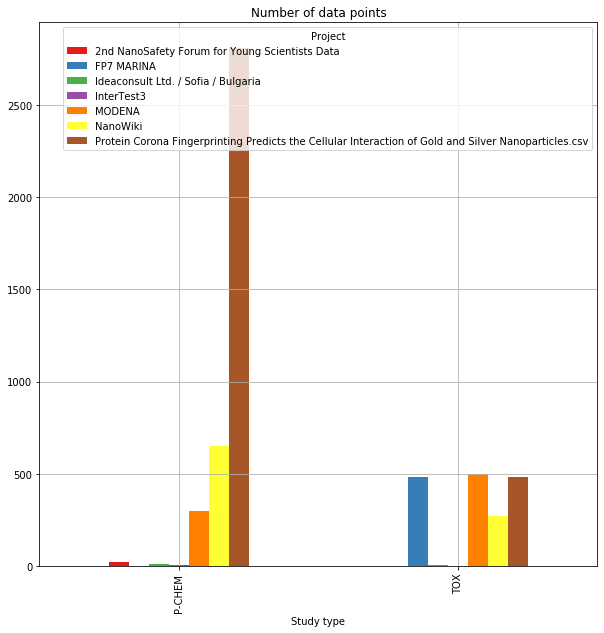

In [11]:
#use this to find where method field is missing
#table = pd.pivot_table(df, values=method_field, index=['topcategory_s','endpointcategory_name'], columns=[ 'owner_name_s'], aggfunc=lambda x: ' '.join(str(v) for v in x)).fillna("")
table = pd.pivot_table(df, values="Number of data points", index=['Study type'], columns=[ 'Project'], aggfunc=np.sum).fillna(0);
display(table)
p = table.plot(kind="bar",  figsize=(10,10) ,sharey =True,title="Number of data points", grid=True)
fig = p.get_figure()
fig.savefig("studytype_datapoints.png")

## Methods summary

In [12]:
#Methods summary
#table = pd.pivot_table(df, values=method_field, index=['Study type','endpointcategory_name'], columns=[ 'Project'], aggfunc=lambda x: ' '.join(str(v) for v in x)).fillna("")
table = pd.pivot_table(df, values=method_field, index=['Study type','endpointcategory_name'], columns=[ 'Project'], aggfunc=lambda x: ';'.join(set(str(v) for v in x))).fillna("")
table.head(20)

Project                                            2nd NanoSafety Forum for Young Scientists Data  \
Study type endpointcategory_name                                                                    
P-CHEM     Appearance                                                                               
           Aspect ratio/shape                                                                       
           Crystallite and grain phase                                                              
           Dustiness                                                                                
           ENM_9000100_SECTION                                                                      
           ENM_9000111_SECTION                                                                      
           ENM_9000112_SECTION                                                                      
           ENM_9000127_SECTION                                                                      
           ENM_9000177_SECTION                                                                      
           ENM_9000195_SECTION                                                                      
           Melting point/freezing point                                                             
           NPO_1204_SECTION                                                                         
           NPO_1539_SECTION                                                                         
           NPO_1694_SECTION                                                                         
           NPO_1914_SECTION                                                                         
           PATO_0000921_SECTION                                                                     
           Particlesize distribution(Granulometry)                                                  
           Physchem(other)                                                                      _   
           Specific surface area                                                                    
           Surface chemistry                                                                        

Project                                            FP7 MARINA  \
Study type endpointcategory_name                                
P-CHEM     Appearance                                           
           Aspect ratio/shape                                   
           Crystallite and grain phase                          
           Dustiness                                            
           ENM_9000100_SECTION                                  
           ENM_9000111_SECTION                                  
           ENM_9000112_SECTION                                  
           ENM_9000127_SECTION                                  
           ENM_9000177_SECTION                                  
           ENM_9000195_SECTION                                  
           Melting point/freezing point                         
           NPO_1204_SECTION                                     
           NPO_1539_SECTION                                     
           NPO_1694_SECTION                                     
           NPO_1914_SECTION                                     
           PATO_0000921_SECTION                                 
           Particlesize distribution(Granulometry)              
           Physchem(other)                                      
           Specific surface area                                
           Surface chemistry                                    

Project                                            Ideaconsult Ltd. / Sofia / Bulgaria  \
Study type endpointcategory_name                                                         
P-CHEM     Appearance                                                                _   
           Aspect ratio/shape                                               

## Number of data points per material and project

Project,2nd NanoSafety Forum for Young Scientists Data,FP7 MARINA,Ideaconsult Ltd. / Sofia / Bulgaria,InterTest3,MODENA,NanoWiki,Protein Corona Fingerprinting Predicts the Cellular Interaction of Gold and Silver Nanoparticles.csv
NM type,,,,,,,
ENM_9000080,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ENM_9000081,1.0,0.0,0.0,0.0,0.0,0.0,0.0
NPO_1540,0.0,0.0,0.0,0.0,0.0,5.0,0.0
NPO_1544,0.0,0.0,0.0,0.0,0.0,27.0,0.0
NPO_1862,0.0,0.0,0.0,0.0,0.0,13.0,0.0
NPO_199,0.0,0.0,0.0,0.0,0.0,10.0,0.0
NPO_602,0.0,0.0,0.0,0.0,56.0,0.0,0.0
NPO_707,1.0,0.0,0.0,0.0,0.0,0.0,0.0
NPO_Bi2O3,0.0,0.0,0.0,0.0,0.0,3.0,0.0


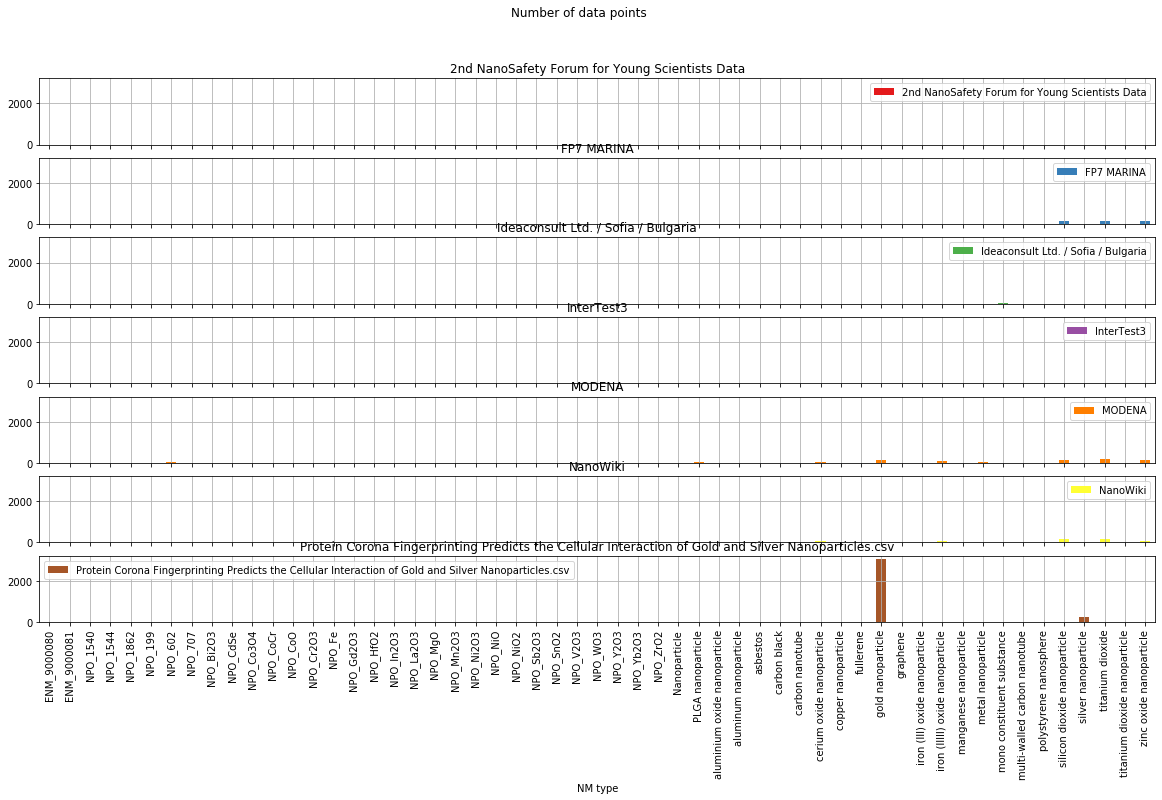

In [13]:
table = pd.pivot_table(df, values="Number of data points", index=['NM type'], columns=[ 'Project'], aggfunc=np.sum).fillna(0);
display(table)
p = table.plot(kind="bar",  figsize=(20,10) ,title="Number of data points", grid=True, stacked =False, sharey=True, subplots=True)
#fig = p.get_figure()
#fig.savefig("nmtype_datapoints.png")

## Number of data points per material and study type

NM type,ENM_9000080,ENM_9000081,NPO_1540,NPO_1544,NPO_1862,NPO_199,NPO_602,NPO_707,NPO_Bi2O3,NPO_CdSe,...,manganese nanoparticle,metal nanoparticle,mono constituent substance,multi-walled carbon nanotube,polystyrene nanosphere,silicon dioxide nanoparticle,silver nanoparticle,titanium dioxide,titanium dioxide nanoparticle,zinc oxide nanoparticle
Study type,,,,,,,,,,,,,,,,,,,,,
P-CHEM,1.0,1.0,3.0,15.0,13.0,10.0,23.0,1.0,1.0,27.0,...,2.0,9.0,10.0,18.0,3.0,136.0,181.0,207.0,1.0,90.0
TOX,0.0,0.0,2.0,12.0,0.0,0.0,33.0,0.0,2.0,0.0,...,0.0,45.0,5.0,3.0,0.0,321.0,64.0,273.0,0.0,247.0


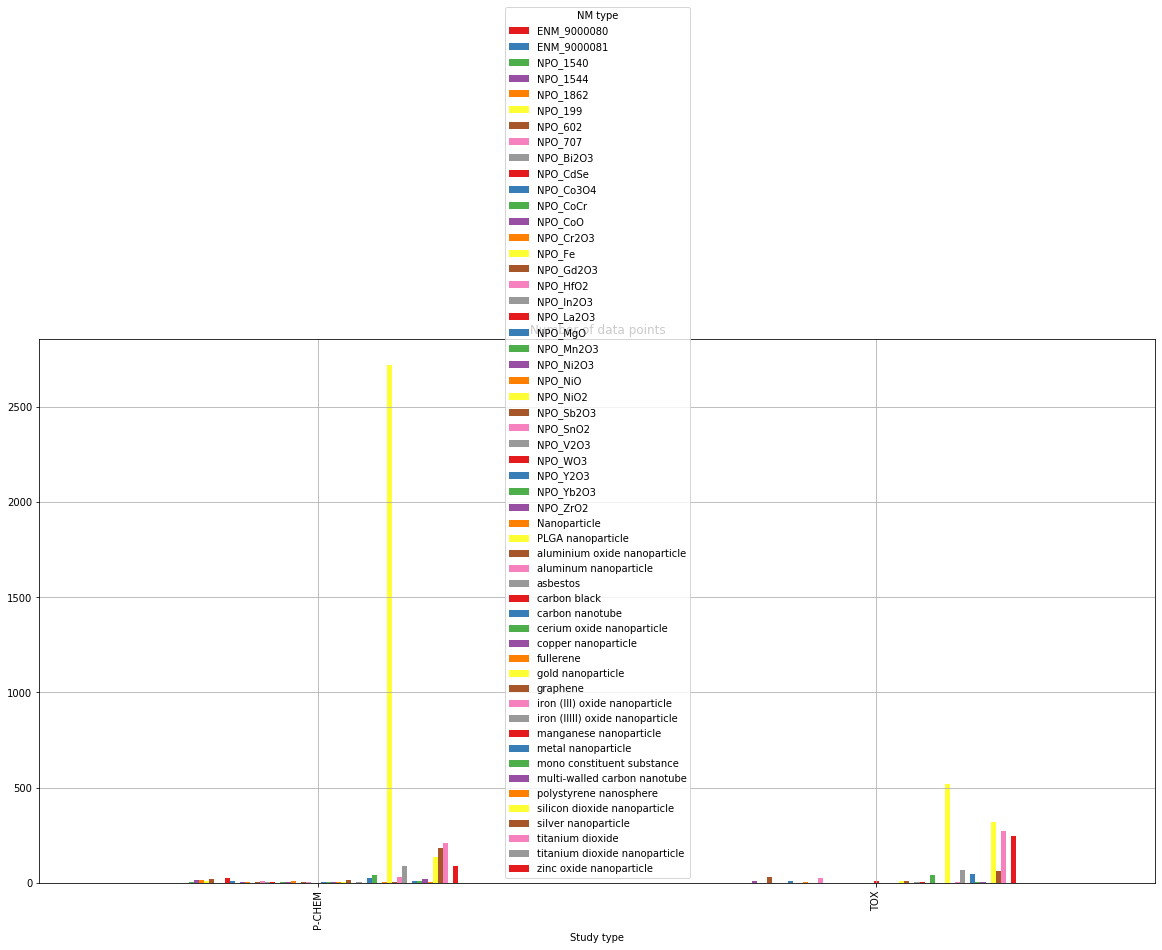

In [14]:
table = pd.pivot_table(df, values="Number of data points", columns=['NM type'], index=[ 'Study type'], aggfunc=np.sum).fillna(0);
display(table)
p = table.plot(kind="bar",  figsize=(20,10) ,title="Number of data points", grid=True, stacked =False, sharey=True, subplots=False)
#fig = p.get_figure()
#fig.savefig("nmtype_datapoints.png")

# Materials

In [15]:
import matplotlib.pyplot as plt
binary = ["#ff0000","#00ff00"]
sns.set_palette(binary)
#red/green palette
#sns.palplot(sns.color_palette())
  
def plot_heatmap(table,q):    
    sns.set_style('ticks')
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(10,10)
    #fig.set_size_inches(11.7/4, 8.27/4)
    sns_plot = sns.heatmap(table, cmap=binary)
    sns_plot.set_title(q)
    sns_plot.get_figure().savefig(q+".png")
    return (sns_plot)


In [16]:
    query_widget_header=widgets.Text(
        placeholder='',
        value="*:*",
        description="Query",
        disabled=False,
        style=style
    )
    display(query_widget_header)

Text(value='*:*', description='Query', placeholder='', style=DescriptionStyle(description_width='initial'))

In [17]:
df = summary(query=query_widget_header.value,fq="type_s:substance",statistics="Number of NM", fields=["owner_name_hs","substanceType_hs","publicname_hs"])    
df.rename(columns={"owner_name_hs" : "Project","topcategory_s":"Study type","substanceType_name": "NM type"},inplace=True)

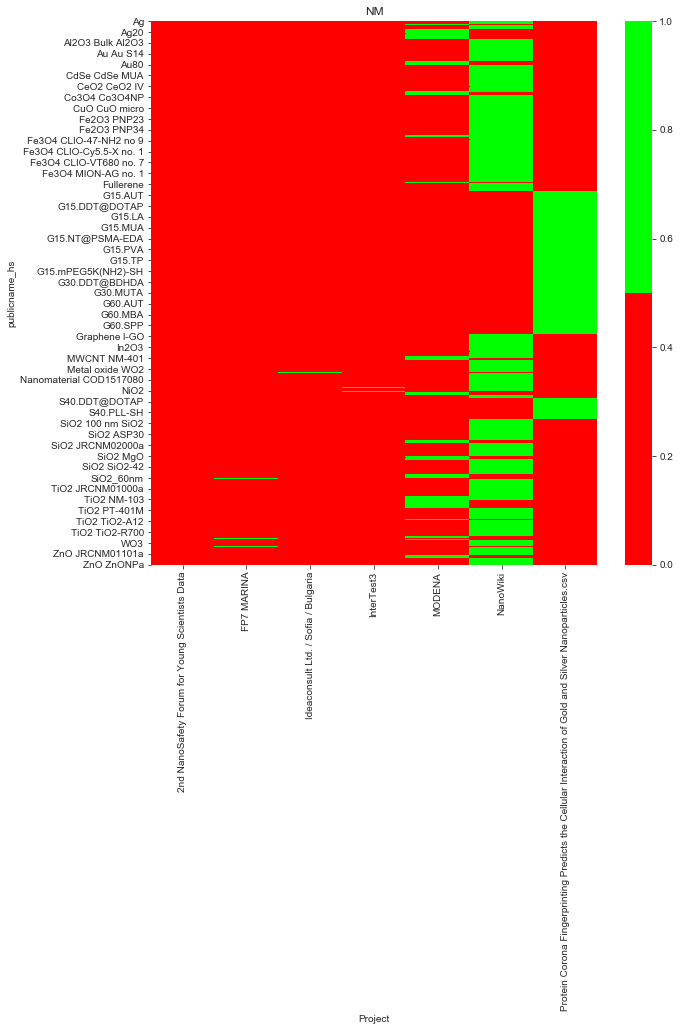

In [18]:
table = pd.pivot_table(df, values="Number of NM", index=['publicname_hs'], columns=[ 'Project'], aggfunc='any').fillna(False)
plot_heatmap(table,"NM")

# Endpoints

In [19]:
def queryEndpoints(_query="topcategory_s:TOX"):
    print(_query)
    df = summary(query=_query,fq="type_s:study",statistics="Number of data points", fields=["topcategory_s","endpointcategory_s","effectendpoint_s","substanceType_s","publicname_s"])        
    df.rename(columns={"owner_name_s" : "Project","topcategory_s":"Study type","substanceType_name": "NM type","endpointcategory_name":"endpoint"},inplace=True)
    table = pd.pivot_table(df, values="Number of data points", index=['NM type'], columns=['endpoint' ], aggfunc='any').fillna(False)
    return (df,table)



topcategory_s:TOX and *:*


,Study type,endpointcategory_s,effectendpoint_s,substanceType_s,publicname_s,Number of data points,NM type,endpointcategory_term,endpoint
0,P-CHEM,PC_GRANULOMETRY_SECTION,INTENSITY MEAN HYDRODYNAMIC DIAMETER,NPO_401,G15.AC,2,gold nanoparticle,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)
1,P-CHEM,PC_GRANULOMETRY_SECTION,INTENSITY MEAN HYDRODYNAMIC DIAMETER,NPO_401,G15.AHT,2,gold nanoparticle,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)
2,P-CHEM,PC_GRANULOMETRY_SECTION,INTENSITY MEAN HYDRODYNAMIC DIAMETER,NPO_401,G15.AUT,2,gold nanoparticle,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)
3,P-CHEM,PC_GRANULOMETRY_SECTION,INTENSITY MEAN HYDRODYNAMIC DIAMETER,NPO_401,G15.Ala-SH,2,gold nanoparticle,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)
4,P-CHEM,PC_GRANULOMETRY_SECTION,INTENSITY MEAN HYDRODYNAMIC DIAMETER,NPO_401,G15.Asn-SH,2,gold nanoparticle,http://purl.obolibrary.org/obo/CHMO_0002119,Particlesize distribution(Granulometry)


endpoint,Acute toxicity-oral,Appearance,Aspect ratio/shape,Carcinogenicity,Cell Viability Assay,Crystallite and grain phase,Cytotoxicity Assay,Dustiness,ENM_9000100_SECTION,ENM_9000111_SECTION,...,NPO_1914_SECTION,PATO_0000921_SECTION,Particlesize distribution(Granulometry),Physchem(other),Proteomics,Specific surface area,Surface chemistry,Toxicity(other),Zeta potential,cell viability ATPquantitationassay
NM type,,,,,,,,,,,,,,,,,,,,,
ENM_9000080,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
ENM_9000081,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
NPO_1540,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
NPO_1544,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False
NPO_1862,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
NPO_199,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NPO_602,False,False,True,False,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
NPO_707,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
NPO_Bi2O3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


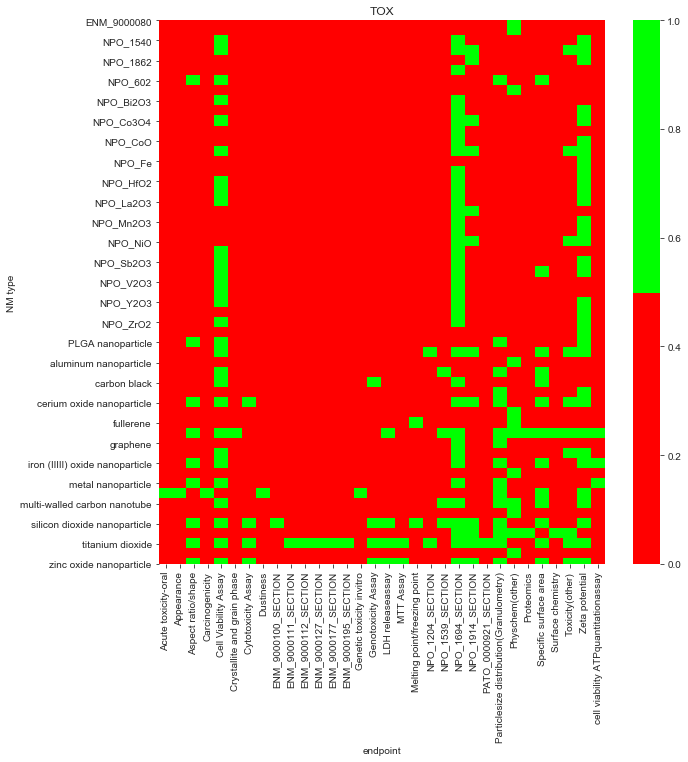

In [20]:
q="TOX"
df,table=queryEndpoints(_query="topcategory_s:"+q + " and " + query_widget.value)
display(df.head())
display(table)
plot_heatmap(table,q)

topcategory_s:P-CHEM and *:*


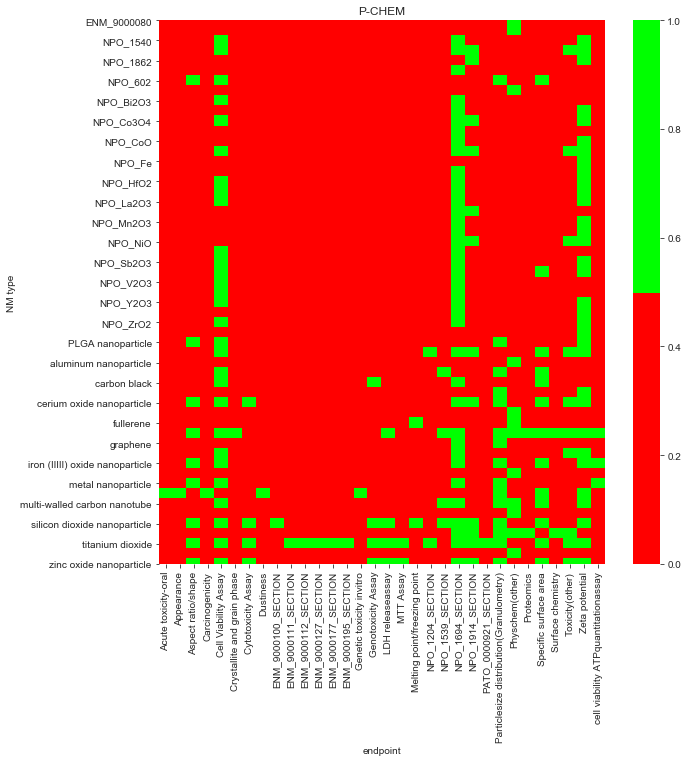

In [21]:
q="P-CHEM"
df,table=queryEndpoints(_query="topcategory_s:"+q + " and " + query_widget.value)
plot_heatmap(table,q)

topcategory_s:ECOTOX and *:*


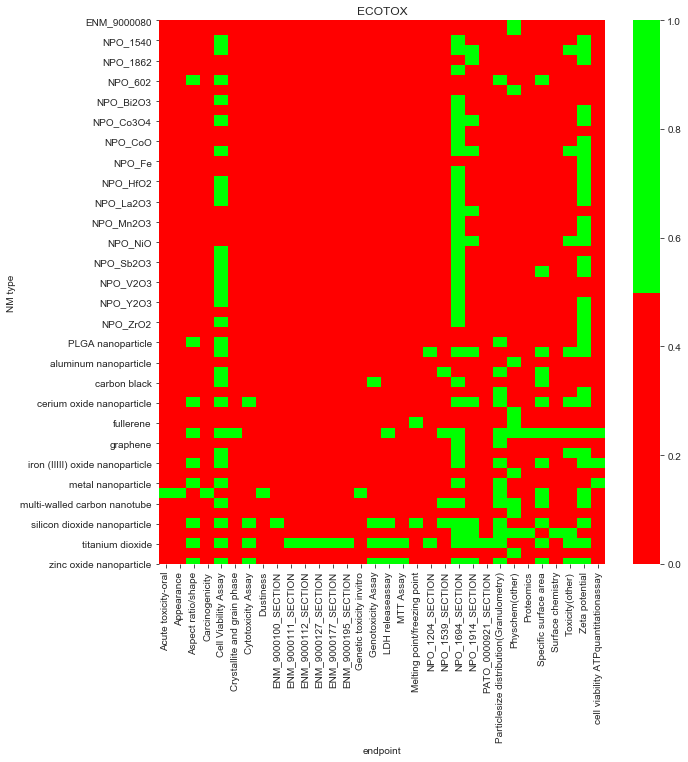

In [22]:
q="ECOTOX"
df,table=queryEndpoints(_query="topcategory_s:"+q + " and " + query_widget.value)
try:
    plot_heatmap(table,q)
except:
    pass